# Continuous Control

---


### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [3]:
env.close()

###  4. The Model
The model is a DDPG (Deep Deterministic Policy Gradient) method implementation. The model consists of two independent neural networks: the Actor and the Critic. The actor is used to compute the best actionb based on a greedy policy which the critic then uses to estmate the value function. 

All the code used in this project was adapted from the learning resources provided in the Udacity DRLND Github: https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum

The hyperparameters used in creating both the actor and critic were: 

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    
    def __init__(self, state_size, action_size, seed, hidden_size=256, hidden_size2=128):
        
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, action_size)
        self.set_weights()
        
    def set_weights(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        out = F.relu(self.fc1(state))
        out = F.relu(self.fc2(out))
        return F.tanh(self.fc3(out))
    
class Critic(nn.Module):
    
    def __init__(self, state_size, action_size, seed, hidden_size=256, hidden_size2=128):
        
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size+action_size, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.set_weights() 
        
    def set_weights(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        if state.dim == 1:
            state = torch.unsqueeze(state, 0)
        
        out1 = F.relu(self.fc1(state))
        out = torch.cat((out1, action), dim=1)
        out = F.relu(self.fc2(out))
        return self.fc3(out)

In [6]:
import numpy as np
import random
import copy
import os
from collections import namedtuple, deque

# from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed) 
        self.hparams = {
            "buffer_size":int(1e5),
            "batch_size":128,
            "gamma":0.99,
            "tau":1e-3,
            "lr":2e-4,
            "weight_decay": 0, 
            "epsilon": 1,
            "epsilon_decay": 0.99
        }
        
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.hparams["lr"])
        
        self.critic_local = Critic(state_size, action_size, seed).to(device)
        self.critic_target = Critic(state_size, action_size, seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.hparams["lr"], weight_decay=self.hparams["weight_decay"])
        
        self.memory = ReplayBuffer(action_size, self.hparams["buffer_size"], self.hparams["batch_size"], seed)
        self.noise = OUNoise(action_size, seed)
       
        
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() * self.hparams['epsilon']
        return np.clip(action, -1, 1)
    
    
    def step(self, states, actions, rewards, next_states, dones):
        
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > self.hparams["batch_size"]:
            experiences = self.memory.sample()
            self.learn(experiences)
    
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.hparams["gamma"] * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)
        
        self.hparams['epsilon'] *= self.hparams['epsilon_decay']
    
    def reset(self):
        self.noise.reset()    
        
    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.hparams["tau"]*local_param.data + (1.0-self.hparams["tau"])*target_param.data)
            
    def print_models(self):
        print(self.actor_local)
        print(self.critic_local)
        
    def save_models(self):
        torch.save(self.actor_local.state_dict(), "actor_weights.pth")
        torch.save(self.critic_local.state_dict(), "critic_weights.pth")
        
    


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size        
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma        
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [7]:
from importlib import reload
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
agent = Agent(state_size, action_size, 42)

In [8]:
agent.hparams

{'buffer_size': 100000,
 'batch_size': 128,
 'gamma': 0.99,
 'tau': 0.001,
 'lr': 0.0002,
 'weight_decay': 0,
 'epsilon': 1,
 'epsilon_decay': 0.99}

And the strcture of the Actor and Critic Networks were as follows:

In [9]:
agent.print_models()

Actor(
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
Critic(
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=260, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


### 5. Train the model

In [10]:
def ddpg(n_episodes=2000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset(train_mode=True)[brain_name].vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if sum(done) > 0:
                break 
                
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode,np.mean(score), np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        if np.mean(scores_deque) > 30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score for next 100 eipisodes: {:.2f}'.format(i_episode - print_every, np.mean(scores_deque)))
            agent.save_models()
            print("Models saved.")
            break
            
        
    return scores

In [11]:
scores = ddpg(n_episodes=1000)

Episode 100	Score: 36.65	Average Score: 29.75
Episode 100	Average Score: 29.75
Episode 101	Score: 36.71	Average Score: 30.11
Environment solved in 1 episodes!	Average Score for next 100 eipisodes: 30.11
Models saved.


### 6. Plotting the mean 100 reward

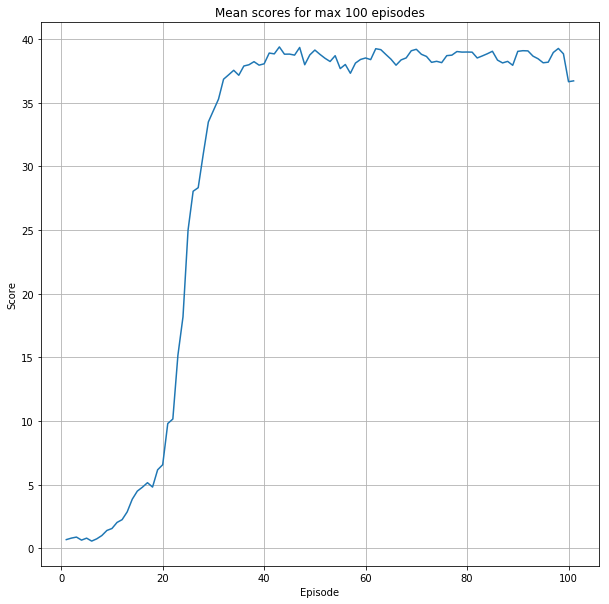

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# plt.plot(np.arange(1, len(scores)+1), np.array([30 for i in range(len(scores)+1)]),'r--')
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('Mean scores for max 100 episodes')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.grid(True)
plt.savefig('rewards.png')
plt.show()


### 7. Ideas for future work

I would like to implement batch normalization to imporve stability of the model. I would also like to play with other models in the course such as A3C and perhaps add support for a decaying learning rate, and other dynamic hyperparameter optimizations. 

---

I would also really like to understand if how to optimize the value of the random seed. My experiments showed it can dramatically change training times, and I was quite surpised at the difference it could make. 

In [ ]:
""" Source:
      - https://stackoverflow.com/questions/48122744/how-to-download-all-files-and-folder-hierarchy-from-jupyter-notebook
"""
import os
import tarfile

def recursive_files(dir_name='.', ignore=None):
    for dir_name,subdirs,files in os.walk(dir_name):
        if ignore and os.path.basename(dir_name) in ignore:
            continue

        for file_name in files:
            if ignore and file_name in ignore:
                continue

            yield os.path.join(dir_name, file_name)

def make_tar_file(dir_name='.', target_file_name='workspace_archive.tar', ignore=None):
    tar = tarfile.open(target_file_name, 'w')

    for file_name in recursive_files(dir_name, ignore):
        tar.add(file_name)

    tar.close()


dir_name = '.'
target_file_name = 'workspace_archive.tar'
# List of files/directories to ignore
ignore = {'.ipynb_checkpoints', '__pycache__', target_file_name}

make_tar_file(dir_name, target_file_name, ignore)